# Connect to SVV

In [1]:
svv_credentials = open('svv_creds.json.txt').read()
import json
svv_creds = json.loads(svv_credentials)

In [2]:
import psycopg2

def get_svv_connection():
    con = psycopg2.connect(dbname = 'svv', host ='svv-rs-prod-bi.cjddijbnvfpr.eu-west-1.redshift.amazonaws.com', \
                           port = 5439, user = svv_creds['user'], password = svv_creds['password'])
    
    return con

# Import the Packages Necessary for Analysis

In [3]:
import pandas as pd
import lifelines as ll ##you will need to pip/conda install this package in the Anaconda Prompt
                       ##(e.g. conda install -c conda-forge lifelines)

# Query the Table Conatining the Tenure and Churned Data

In [4]:
query_data = "Select * from sandbox.rw_hub_plus_survival_20200407"

df_survival = pd.DataFrame()

try: 
    con = get_svv_connection()

    cur = con.cursor()
    cur.execute(query_data)

    colnames = [desc[0] for desc in cur.description]
    df_survival = pd.DataFrame(cur.fetchall(), columns = colnames)
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

# Check the Dataset 

In [5]:
df_survival.head()

,viewer_id,tenure,churned,cluster
0,00218114-d8af-4627-8685-fd4811895e37,1,1,love_island
1,00671c60-6ceb-4760-9617-6e677f5e3b68,14,0,drama
2,00a34a68-e720-463e-a248-77c2f1820ecf,3,1,love_island
3,00cba00e-f76e-454a-a9d7-d28de6f1e0a5,1,1,sport_family
4,00fd717d-6c02-417d-a7f1-71f7f535366d,8,0,love_island


# Check Data Types and for Nulls

In [6]:
df_survival.dtypes

viewer_id    object
tenure        int64
churned       int64
cluster      object
dtype: object

In [7]:
df_survival.isnull().values.any()

True

In [8]:
df_survival['viewer_id'].isnull().values.any()

False

In [9]:
df_survival['tenure'].isnull().values.any()

False

In [10]:
df_survival['churned'].isnull().values.any()

False

In [11]:
df_survival['cluster'].isnull().values.any()

True

# Drop NAs

In [12]:
df_survival = df_survival.dropna()

In [13]:
df_survival = df_survival.set_index('viewer_id')
df_survival.head()

,tenure,churned,cluster
viewer_id,,,
00218114-d8af-4627-8685-fd4811895e37,1,1,love_island
00671c60-6ceb-4760-9617-6e677f5e3b68,14,0,drama
00a34a68-e720-463e-a248-77c2f1820ecf,3,1,love_island
00cba00e-f76e-454a-a9d7-d28de6f1e0a5,1,1,sport_family
00fd717d-6c02-417d-a7f1-71f7f535366d,8,0,love_island


# Create the Kaplan-Meier Fitter and Apply it to the Hub+ Clusters

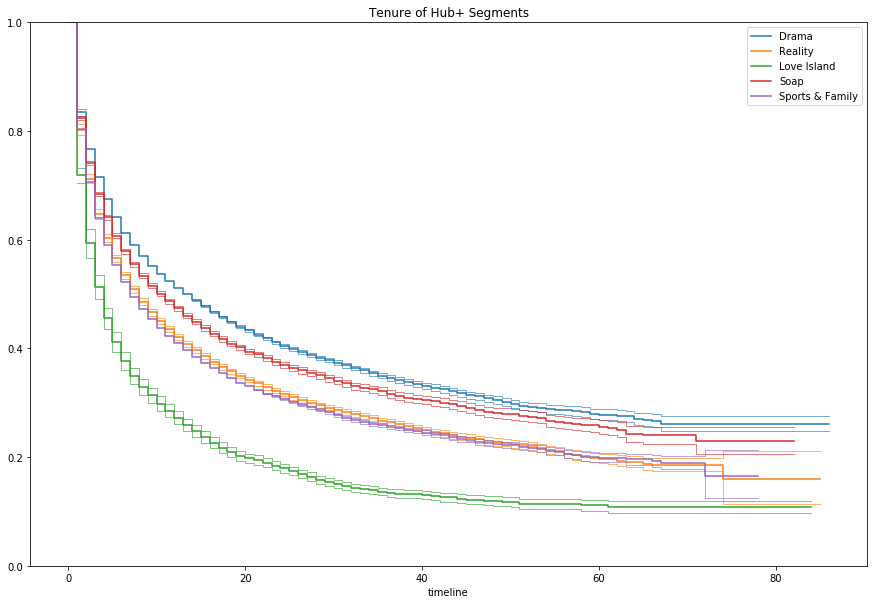

In [14]:
T = df_survival['tenure']
E = df_survival['churned']

import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

plt.figure(figsize = (15,10))

ax = plt.subplot(111)

cluster_0 = (df_survival["cluster"] == "drama")
cluster_1 = (df_survival["cluster"] == "reality")
cluster_2 = (df_survival["cluster"] == "love_island")
cluster_3 = (df_survival["cluster"] == "soaps")
cluster_4 = (df_survival["cluster"] == "sport_family")
kmf.fit(T[cluster_0], event_observed = E[cluster_0], label = "Drama")
kmf.plot(ax = ax, ci_force_lines = True)
kmf.fit(T[cluster_1], event_observed = E[cluster_1], label = "Reality")
kmf.plot(ax = ax, ci_force_lines = True)
kmf.fit(T[cluster_2], event_observed = E[cluster_2], label = "Love Island")
kmf.plot(ax = ax, ci_force_lines = True)
kmf.fit(T[cluster_3], event_observed = E[cluster_3], label = "Soap")
kmf.plot(ax = ax, ci_force_lines = True)
kmf.fit(T[cluster_4], event_observed = E[cluster_4], label = "Sports & Family")
kmf.plot(ax = ax, ci_force_lines = True)

plt.ylim(0, 1);
plt.title("Tenure of Hub+ Segments");

# Use the Log-Rank Test to See Whether There is Actually a Difference Between Reality and Sport & Family

In [15]:
from lifelines.statistics import logrank_test

test_results = logrank_test(T[cluster_1], T[cluster_4], E[cluster_1], E[cluster_4], alpha = 0.99)

test_results.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
       27.1679 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


The Kaplan-Meier Estimator is a non-parametric statistic used to estimate the survival function from the data. In this case it is used to estimate the survival function of each Hub+ segment. It shows the proportion of each cluster who have not churned after each month from the start of their subscription.

You can see the difference in the clusters, Love Islanders tend to churn much more quickly than the other clusters.

# Create the Nelson-Aalen Fitter (for the Cumulative Hazard Function) and Fit it to the Hub+ Clusters

<Figure size 1080x720 with 0 Axes>

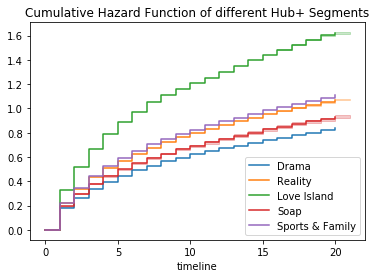

In [16]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

plt.figure(figsize = (15,10))

naf.fit(T[cluster_0], event_observed = E[cluster_0], label = "Drama")
ax = naf.plot(loc = slice(0, 20)) ##capped at 20 to focus on the more important region, to exlcude outliers
naf.fit(T[cluster_1], event_observed = E[cluster_1], label = "Reality")
naf.plot(ax = ax, loc = slice(0, 20))
naf.fit(T[cluster_2], event_observed = E[cluster_2], label = "Love Island")
naf.plot(ax = ax, loc = slice(0, 20))
naf.fit(T[cluster_3], event_observed = E[cluster_3], label = "Soap")
naf.plot(ax = ax, loc = slice(0, 20))
naf.fit(T[cluster_4], event_observed = E[cluster_4], label = "Sports & Family")
naf.plot(ax = ax, loc = slice(0, 20))

plt.title("Cumulative Hazard Function of different Hub+ Segments");

The Nelson-Aalen estimator is a non-parametric estimator of the Cumulative Hazard function in the case of censored data. It is used to estimate the cumulative number of expected events (in this case churns).

Hazard Function: Assume that a user has not churned by time t, the hazard rate is the probability that they will have churned by time t+dt (e.g they have not churned after month 1, what is the probability that they will have churned by month 1+1 (2)).
The cumulative hazard rate is the sum of all hazard rates up until that time.

In [17]:
kmf.fit(T[cluster_0], event_observed = E[cluster_0], label = "Drama")
kmf.median_

13.0

In [18]:
kmf.fit(T[cluster_1], event_observed = E[cluster_1], label = "Reality")
kmf.median_

8.0

In [19]:
kmf.fit(T[cluster_2], event_observed = E[cluster_2], label = "Love Islanders")
kmf.median_

4.0

In [20]:
kmf.fit(T[cluster_3], event_observed = E[cluster_3], label = "Soaps")
kmf.median_

11.0

In [21]:
kmf.fit(T[cluster_4], event_observed = E[cluster_4], label = "Sports & Family")
kmf.median_

7.0